# 08 - Hybrid: Rule-Based + TF-IDF Logistic Regression

**Approach**: Hybrid classification combining rule-based (for exact matches) and TF-IDF + LogReg classifiers.

**Hybrid Strategy**:
- **Department**: Rule-based for EXACT matches (100% accuracy) → TF-IDF for non-exact matches
- **Seniority**: TF-IDF + LogReg only

**Key Requirements**:
- CV-level split (no data leakage between train/val/test)
- Training on ALL labeled entries (ACTIVE + INACTIVE)
- Evaluation ONLY on ACTIVE entries
- Best-of-both-worlds: Precision of rules + Generalization of ML

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Tuple, Any
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import rule-based classifier for hybrid approach
import sys
sys.path.append('../')
from src.data.loader import load_label_lists
from src.models.rule_based import RuleConfig, create_department_classifier

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
MODELS_DIR = Path('../models')
RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

%matplotlib inline

## 1. Data Loading Functions

In [2]:
def load_linkedin_cvs(filepath: Path) -> List[Dict[str, Any]]:
    """
    Load LinkedIn CV JSON data.
    
    Args:
        filepath: Path to JSON file
        
    Returns:
        List of CV dictionaries
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data if isinstance(data, list) else [data]


def create_input_text(entry: Dict[str, Any], include_org: bool = True) -> str:
    """
    Create input text from a job entry.
    
    Args:
        entry: Job entry dictionary
        include_org: Whether to include organization name
        
    Returns:
        Concatenated text string
    """
    parts = []
    
    # Add position/title
    position = entry.get('position', '') or entry.get('title', '')
    if position and isinstance(position, str):
        parts.append(position.strip())
    
    # Add organization
    if include_org:
        org = entry.get('organization', '') or entry.get('company', '')
        if org and isinstance(org, str):
            parts.append(org.strip())
    
    # Add description (first 200 chars)
    desc = entry.get('description', '') or entry.get('text', '')
    if desc and isinstance(desc, str):
        desc_clean = desc.strip()[:200]
        if desc_clean:
            parts.append(desc_clean)
    
    return ' '.join(parts) if parts else 'Unknown'


def extract_samples_from_cvs(cvs: List[Dict], cv_indices: List[int], 
                            is_annotated: bool = True) -> pd.DataFrame:
    """
    Extract job entry samples from CVs.
    
    Args:
        cvs: List of CV dictionaries
        cv_indices: Indices of CVs to extract from
        is_annotated: Whether CVs have department/seniority labels
        
    Returns:
        DataFrame with columns: cv_id, input_text, title, status, department, seniority
    """
    samples = []
    
    for cv_idx in cv_indices:
        if cv_idx >= len(cvs):
            continue
            
        cv = cvs[cv_idx]
        entries = cv if isinstance(cv, list) else cv.get('positions', [])
        
        for entry in entries:
            if not isinstance(entry, dict):
                continue
                
            # Create input text (for TF-IDF)
            text = create_input_text(entry, include_org=True)
            
            # Extract title only (for rule-based)
            title = entry.get('position', '') or entry.get('title', '')
            if not title or not isinstance(title, str):
                title = 'Unknown'
            
            # Get status (default to ACTIVE if missing)
            status = entry.get('status', 'ACTIVE')
            if not isinstance(status, str):
                status = 'ACTIVE'
            
            sample = {
                'cv_id': cv_idx,
                'input_text': text,
                'title': title.strip(),  # Add title for rule-based
                'status': status.upper()
            }
            
            # Add labels if annotated
            if is_annotated:
                sample['department'] = entry.get('department', 'Other')
                sample['seniority'] = entry.get('seniority', 'Professional')
            
            samples.append(sample)
    
    return pd.DataFrame(samples)

## 2. CV-Level Splitting

In [3]:
def split_cvs_train_val_test(n_cvs: int, train_ratio: float = 0.8, 
                              val_ratio: float = 0.1, 
                              random_seed: int = 42) -> Tuple[List[int], List[int], List[int]]:
    """
    Split CV indices into train/val/test sets.
    
    Args:
        n_cvs: Total number of CVs
        train_ratio: Proportion for training
        val_ratio: Proportion for validation
        random_seed: Random seed for reproducibility
        
    Returns:
        Tuple of (train_indices, val_indices, test_indices)
    """
    cv_indices = list(range(n_cvs))
    
    # First split: train + (val+test)
    train_idx, temp_idx = train_test_split(
        cv_indices, 
        test_size=(1 - train_ratio),
        random_state=random_seed,
        shuffle=True
    )
    
    # Second split: val and test
    val_size = val_ratio / (1 - train_ratio)
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=(1 - val_size),
        random_state=random_seed,
        shuffle=True
    )
    
    return train_idx, val_idx, test_idx


print("Loading annotated LinkedIn CVs...")
annotated_cvs = load_linkedin_cvs(DATA_DIR / 'linkedin-cvs-annotated.json')
print(f" Loaded {len(annotated_cvs)} annotated CVs")

# CV-level split
train_cv_idx, val_cv_idx, test_cv_idx = split_cvs_train_val_test(
    len(annotated_cvs), 
    train_ratio=0.8, 
    val_ratio=0.1,
    random_seed=RANDOM_SEED
)

print(f"\nCV-Level Split:")
print(f"  Train: {len(train_cv_idx)} CVs")
print(f"  Val:   {len(val_cv_idx)} CVs")
print(f"  Test:  {len(test_cv_idx)} CVs")

Loading annotated LinkedIn CVs...
 Loaded 609 annotated CVs

CV-Level Split:
  Train: 487 CVs
  Val:   61 CVs
  Test:  61 CVs


## 3. Extract Samples from Splits

In [4]:
# Extract samples from each split
print("\nExtracting samples from CVs...")
train_df = extract_samples_from_cvs(annotated_cvs, train_cv_idx, is_annotated=True)
val_df = extract_samples_from_cvs(annotated_cvs, val_cv_idx, is_annotated=True)
test_df = extract_samples_from_cvs(annotated_cvs, test_cv_idx, is_annotated=True)

print(f"\nSample Counts (ALL entries):")
print(f"  Train: {len(train_df)} entries ({train_df['status'].value_counts().to_dict()})")
print(f"  Val:   {len(val_df)} entries ({val_df['status'].value_counts().to_dict()})")
print(f"  Test:  {len(test_df)} entries ({test_df['status'].value_counts().to_dict()})")

# Filter for evaluation (ACTIVE only)
val_active_df = val_df[val_df['status'] == 'ACTIVE'].copy()
test_active_df = test_df[test_df['status'] == 'ACTIVE'].copy()

print(f"\nSample Counts (ACTIVE only for evaluation):")
print(f"  Val:   {len(val_active_df)} ACTIVE entries")
print(f"  Test:  {len(test_active_df)} ACTIVE entries")

# Display sample
print(f"\nSample entries:")
print(train_df[['title', 'input_text', 'status', 'department', 'seniority']].head(3))


Extracting samples from CVs...

Sample Counts (ALL entries):
  Train: 2108 entries ({'INACTIVE': 1525, 'ACTIVE': 487, 'UNKNOWN': 96})
  Val:   298 entries ({'INACTIVE': 218, 'ACTIVE': 73, 'UNKNOWN': 7})
  Test:  232 entries ({'INACTIVE': 154, 'ACTIVE': 63, 'UNKNOWN': 15})

Sample Counts (ACTIVE only for evaluation):
  Val:   73 ACTIVE entries
  Test:  63 ACTIVE entries

Sample entries:
                                               title  \
0  Architektin, Fachgebietsleitung Technisches un...   
1        Projektmanagement, Organisationsentwicklung   
2                                        Architektin   

                                          input_text    status  \
0  Architektin, Fachgebietsleitung Technisches un...    ACTIVE   
1  Projektmanagement, Organisationsentwicklung Kr...  INACTIVE   
2  Architektin Wilma Bau- und Entwicklungsgesells...  INACTIVE   

           department     seniority  
0  Project Management          Lead  
1  Project Management  Professional  
2     

In [5]:
# Load lookup tables for rule-based classifier
print("Loading lookup tables for rule-based classifier...")
dept_df, sen_df = load_label_lists(DATA_DIR, max_per_class=None)

print(f"Department lookup: {len(dept_df):,} examples")
print(f"Seniority lookup:  {len(sen_df):,} examples")

# Create rule-based department classifier
config_dept = RuleConfig(
    fuzzy_threshold=0.8,
    use_text_normalization=True,
    default_label="Other"
)

dept_clf_rule = create_department_classifier(dept_df, config=config_dept)
print("\nRule-based department classifier created for hybrid approach")
print("   Will be used for EXACT matches only")

Loading lookup tables for rule-based classifier...
Applying encoding fix...
  Deduplication: 10145 -> 10145 (removed 0 duplicates)
  Deduplication: 9428 -> 9428 (removed 0 duplicates)
Department lookup: 10,145 examples
Seniority lookup:  9,428 examples

Rule-based department classifier created for hybrid approach
   Will be used for EXACT matches only


In [6]:
# Test rule-based classifier on validation set
print("Testing rule-based classifier on validation set...")
print("=" * 80)

# IMPORTANT: Use 'title' column (job title only), NOT 'input_text' (which includes org + desc)
val_titles = val_active_df['title'].tolist()
val_predictions = dept_clf_rule.predict_with_details(val_titles)

# Count matching methods
method_counts = {}
for pred, conf, method in val_predictions:
    method_counts[method] = method_counts.get(method, 0) + 1

print(f"\nValidation Set ({len(val_titles)} ACTIVE entries):")
print("-" * 80)
for method, count in sorted(method_counts.items(), key=lambda x: x[1], reverse=True):
    pct = 100 * count / len(val_titles)
    print(f"  {method.upper():<15}: {count:>4} ({pct:>5.1f}%)")
print("-" * 80)

# Test on test set
# IMPORTANT: Use 'title' column (job title only), NOT 'input_text'
test_titles = test_active_df['title'].tolist()
test_predictions = dept_clf_rule.predict_with_details(test_titles)

# Count matching methods
test_method_counts = {}
for pred, conf, method in test_predictions:
    test_method_counts[method] = test_method_counts.get(method, 0) + 1

print(f"\nTest Set ({len(test_titles)} ACTIVE entries):")
print("-" * 80)
for method, count in sorted(test_method_counts.items(), key=lambda x: x[1], reverse=True):
    pct = 100 * count / len(test_titles)
    print(f"  {method.upper():<15}: {count:>4} ({pct:>5.1f}%)")
print("-" * 80)

# Show some exact match examples if any exist
exact_matches_val = [(title, pred, conf) for title, (pred, conf, method) in zip(val_titles, val_predictions) if method == 'exact']
exact_matches_test = [(title, pred, conf) for title, (pred, conf, method) in zip(test_titles, test_predictions) if method == 'exact']

if exact_matches_val:
    print(f"\nEXACT MATCHES IN VALIDATION SET ({len(exact_matches_val)} found):")
    print("-" * 80)
    for i, (title, pred, conf) in enumerate(exact_matches_val[:5], 1):
        print(f"{i}. '{title[:60]}...' → {pred}")
else:
    print(f"\nNO EXACT MATCHES IN VALIDATION SET")

if exact_matches_test:
    print(f"\nEXACT MATCHES IN TEST SET ({len(exact_matches_test)} found):")
    print("-" * 80)
    for i, (title, pred, conf) in enumerate(exact_matches_test[:5], 1):
        print(f"{i}. '{title[:60]}...' → {pred}")
else:
    print(f"\nNO EXACT MATCHES IN TEST SET")


Testing rule-based classifier on validation set...

Validation Set (73 ACTIVE entries):
--------------------------------------------------------------------------------
  DEFAULT        :   41 ( 56.2%)
  KEYWORD        :   16 ( 21.9%)
  EXACT          :    7 (  9.6%)
  SUBSTRING      :    7 (  9.6%)
  FUZZY          :    2 (  2.7%)
--------------------------------------------------------------------------------

Test Set (63 ACTIVE entries):
--------------------------------------------------------------------------------
  DEFAULT        :   36 ( 57.1%)
  KEYWORD        :   10 ( 15.9%)
  FUZZY          :    7 ( 11.1%)
  EXACT          :    5 (  7.9%)
  SUBSTRING      :    5 (  7.9%)
--------------------------------------------------------------------------------

EXACT MATCHES IN VALIDATION SET (7 found):
--------------------------------------------------------------------------------
1. 'Key-Account-Manager...' → Sales
2. 'Projektleiter...' → Project Management
3. 'Digital Marketing M

## 4. Load Rule-Based Classifier for Hybrid Approach

For department classification, we use a **hybrid strategy**:
- **Exact matches**: Use rule-based classifier (100% accuracy)
- **Non-exact matches**: Use TF-IDF + LogReg classifier

## 5. Build TF-IDF Pipelines

Using FeatureUnion to combine:
- Word n-grams (1-2)
- Character n-grams (3-5)

In [7]:
def create_tfidf_pipeline(max_features_word: int = 5000, 
                        max_features_char: int = 3000) -> FeatureUnion:
    """
    Create TF-IDF feature union combining word and character n-grams.
    
    Args:
        max_features_word: Max features for word n-grams
        max_features_char: Max features for character n-grams
        
    Returns:
        FeatureUnion pipeline
    """
    return FeatureUnion([
        ('word_ngrams', TfidfVectorizer(
            max_features=max_features_word,
            ngram_range=(1, 2),
            analyzer='word',
            lowercase=True,
            min_df=2,
            max_df=0.95
        )),
        ('char_ngrams', TfidfVectorizer(
            max_features=max_features_char,
            ngram_range=(3, 5),
            analyzer='char',
            lowercase=True,
            min_df=2,
            max_df=0.95
        ))
    ])


# Create feature extractors
print("Creating TF-IDF pipelines...")
dept_vectorizer = create_tfidf_pipeline(max_features_word=5000, max_features_char=3000)
sen_vectorizer = create_tfidf_pipeline(max_features_word=3000, max_features_char=2000)

print("TF-IDF pipelines created")

Creating TF-IDF pipelines...
TF-IDF pipelines created


## 6. Train Department Classifier

Train on ALL entries (ACTIVE + INACTIVE) from train CVs.

In [8]:
# Prepare training data (ALL entries)
X_train_dept = train_df['input_text'].tolist()
y_train_dept = train_df['department'].tolist()

print(f"Training Department classifier...")
print(f"  Training samples: {len(X_train_dept)}")
print(f"  Classes: {len(set(y_train_dept))}")

# Fit vectorizer and transform
dept_X_train = dept_vectorizer.fit_transform(X_train_dept)
print(f"  Feature dimension: {dept_X_train.shape[1]:,}")

# Train classifier
dept_classifier = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=RANDOM_SEED,
    class_weight='balanced'
)

dept_classifier.fit(dept_X_train, y_train_dept)
print("Department classifier trained")

# Evaluate on ACTIVE entries only
dept_X_val = dept_vectorizer.transform(val_active_df['input_text'].tolist())
dept_y_val = val_active_df['department'].tolist()
dept_val_preds = dept_classifier.predict(dept_X_val)
dept_val_acc = accuracy_score(dept_y_val, dept_val_preds)

print(f"\nValidation (ACTIVE only): {dept_val_acc:.4f} accuracy")

Training Department classifier...
  Training samples: 2108
  Classes: 11
  Feature dimension: 5,536
Department classifier trained

Validation (ACTIVE only): 0.7397 accuracy


## 7. Train Seniority Classifier

In [9]:
# Prepare training data (ALL entries)
X_train_sen = train_df['input_text'].tolist()
y_train_sen = train_df['seniority'].tolist()

print(f"Training Seniority classifier...")
print(f"  Training samples: {len(X_train_sen)}")
print(f"  Classes: {len(set(y_train_sen))}")

# Fit vectorizer and transform
sen_X_train = sen_vectorizer.fit_transform(X_train_sen)
print(f"  Feature dimension: {sen_X_train.shape[1]:,}")

# Train classifier
sen_classifier = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=RANDOM_SEED,
    class_weight='balanced'
)

sen_classifier.fit(sen_X_train, y_train_sen)
print("Seniority classifier trained")

# Evaluate on ACTIVE entries only
sen_X_val = sen_vectorizer.transform(val_active_df['input_text'].tolist())
sen_y_val = val_active_df['seniority'].tolist()
sen_val_preds = sen_classifier.predict(sen_X_val)
sen_val_acc = accuracy_score(sen_y_val, sen_val_preds)

print(f"\nValidation (ACTIVE only): {sen_val_acc:.4f} accuracy")

Training Seniority classifier...
  Training samples: 2108
  Classes: 6
  Feature dimension: 4,536
Seniority classifier trained

Validation (ACTIVE only): 0.8493 accuracy


## 8. Evaluation on Test Set (ACTIVE entries only)

In [10]:
def evaluate_classifier_with_hybrid(dept_vectorizer, dept_tfidf_classifier, 
                                dept_rule_classifier,
                                sen_vectorizer, sen_classifier,
                                test_df: pd.DataFrame) -> Tuple[Dict[str, float], Dict[str, float]]:
    """
    Evaluate classifiers on ACTIVE test entries with hybrid approach for department.
    
    Hybrid Strategy for Department:
    - Exact matches: Use rule-based prediction
    - Non-exact matches: Use TF-IDF prediction
    
    Args:
        dept_vectorizer: Department TF-IDF vectorizer
        dept_tfidf_classifier: Department TF-IDF classifier
        dept_rule_classifier: Department rule-based classifier
        sen_vectorizer: Seniority TF-IDF vectorizer
        sen_classifier: Seniority classifier
        test_df: Test dataframe (ACTIVE entries only)
        
    Returns:
        Tuple of (dept_metrics, sen_metrics) dictionaries
    """
    
    # IMPORTANT: Use 'title' for rule-based (job title only), 'input_text' for TF-IDF (full text)
    dept_titles_rule = test_df['title'].tolist()  # For rule-based
    dept_titles_tfidf = test_df['input_text'].tolist()  # For TF-IDF
    dept_true = test_df['department'].tolist()
    
    # Get rule-based predictions with method info (using job title only)
    rule_predictions_with_details = dept_rule_classifier.predict_with_details(dept_titles_rule)
    
    # Get TF-IDF predictions (using full text)
    dept_X_test = dept_vectorizer.transform(dept_titles_tfidf)
    tfidf_predictions = dept_tfidf_classifier.predict(dept_X_test)
    
    # Combine: Use rule-based for exact matches, TF-IDF for the rest
    dept_predictions = []
    exact_match_count = 0
    tfidf_match_count = 0
    
    for i, (rule_pred, rule_conf, rule_method) in enumerate(rule_predictions_with_details):
        if rule_method == 'exact':
            dept_predictions.append(rule_pred)
            exact_match_count += 1
        else:
            dept_predictions.append(tfidf_predictions[i])
            tfidf_match_count += 1
    
    # Calculate department metrics
    dept_accuracy = accuracy_score(dept_true, dept_predictions)
    dept_precision, dept_recall, dept_f1_macro, _ = precision_recall_fscore_support(
        dept_true, dept_predictions, average='macro', zero_division=0
    )
    _, _, dept_f1_weighted, _ = precision_recall_fscore_support(
        dept_true, dept_predictions, average='weighted', zero_division=0
    )
    
    
    dept_metrics = {
        'accuracy': float(dept_accuracy),
        'precision_macro': float(dept_precision),
        'recall_macro': float(dept_recall),
        'f1_macro': float(dept_f1_macro),
        'f1_weighted': float(dept_f1_weighted),
        'test_samples': len(dept_true),
        'exact_matches': exact_match_count,
        'tfidf_matches': tfidf_match_count
    }

    sen_X_test = sen_vectorizer.transform(test_df['input_text'].tolist())
    sen_true = test_df['seniority'].tolist()
    sen_predictions = sen_classifier.predict(sen_X_test)
    
    # Calculate seniority metrics
    sen_accuracy = accuracy_score(sen_true, sen_predictions)
    sen_precision, sen_recall, sen_f1_macro, _ = precision_recall_fscore_support(
        sen_true, sen_predictions, average='macro', zero_division=0
    )
    _, _, sen_f1_weighted, _ = precision_recall_fscore_support(
        sen_true, sen_predictions, average='weighted', zero_division=0
    )
    
    sen_metrics = {
        'accuracy': float(sen_accuracy),
        'precision_macro': float(sen_precision),
        'recall_macro': float(sen_recall),
        'f1_macro': float(sen_f1_macro),
        'f1_weighted': float(sen_f1_weighted),
        'test_samples': len(sen_true)
    }
    
    return dept_metrics, sen_metrics, dept_predictions, sen_predictions, dept_true, sen_true

In [11]:
# Evaluate with hybrid approach
dept_metrics, sen_metrics, dept_predictions, sen_predictions, dept_true, sen_true = evaluate_classifier_with_hybrid(
    dept_vectorizer, dept_classifier, dept_clf_rule,
    sen_vectorizer, sen_classifier,
    test_active_df
)

In [12]:
# Department Results
print(f"\n{'='*80}")
print(f"DEPARTMENT - Test Set Results (HYBRID APPROACH)")
print(f"{'='*80}")
print(f"Test samples:        {dept_metrics['test_samples']}")
print(f"  Exact matches:     {dept_metrics['exact_matches']} ({100*dept_metrics['exact_matches']/dept_metrics['test_samples']:.1f}%) → Rule-based")
print(f"  Non-exact matches: {dept_metrics['tfidf_matches']} ({100*dept_metrics['tfidf_matches']/dept_metrics['test_samples']:.1f}%) → TF-IDF")
print(f"\nAccuracy:            {dept_metrics['accuracy']:.4f}")
print(f"Precision (macro):   {dept_metrics['precision_macro']:.4f}")
print(f"Recall (macro):      {dept_metrics['recall_macro']:.4f}")
print(f"F1 (macro):          {dept_metrics['f1_macro']:.4f}")
print(f"F1 (weighted):       {dept_metrics['f1_weighted']:.4f}")
print(f"{'='*80}")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(dept_true, dept_predictions, zero_division=0))


DEPARTMENT - Test Set Results (HYBRID APPROACH)
Test samples:        63
  Exact matches:     5 (7.9%) → Rule-based
  Non-exact matches: 58 (92.1%) → TF-IDF

Accuracy:            0.7778
Precision (macro):   0.6131
Recall (macro):      0.6604
F1 (macro):          0.6169
F1 (weighted):       0.7897

Detailed Classification Report:
                        precision    recall  f1-score   support

        Administrative       0.00      0.00      0.00         0
  Business Development       0.50      0.50      0.50         2
            Consulting       0.75      0.75      0.75         4
       Human Resources       1.00      1.00      1.00         1
Information Technology       0.40      0.50      0.44         4
             Marketing       0.50      0.50      0.50         2
                 Other       0.90      0.85      0.88        41
    Project Management       0.75      0.50      0.60         6
            Purchasing       0.33      1.00      0.50         1
                 Sales      

In [13]:
# Seniority Results
print(f"\n{'='*80}")
print(f"SENIORITY - Test Set Results (TF-IDF)")
print(f"{'='*80}")
print(f"Test samples:        {sen_metrics['test_samples']}")
print(f"Accuracy:            {sen_metrics['accuracy']:.4f}")
print(f"Precision (macro):   {sen_metrics['precision_macro']:.4f}")
print(f"Recall (macro):      {sen_metrics['recall_macro']:.4f}")
print(f"F1 (macro):          {sen_metrics['f1_macro']:.4f}")
print(f"F1 (weighted):       {sen_metrics['f1_weighted']:.4f}")
print(f"{'='*80}")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(sen_true, sen_predictions, zero_division=0))


SENIORITY - Test Set Results (TF-IDF)
Test samples:        63
Accuracy:            0.8095
Precision (macro):   0.7212
Recall (macro):      0.6996
F1 (macro):          0.7054
F1 (weighted):       0.8356

Detailed Classification Report:
              precision    recall  f1-score   support

    Director       0.83      1.00      0.91         5
      Junior       0.00      0.00      0.00         0
        Lead       0.70      0.78      0.74         9
  Management       0.89      0.89      0.89        18
Professional       0.90      0.73      0.81        26
      Senior       1.00      0.80      0.89         5

    accuracy                           0.81        63
   macro avg       0.72      0.70      0.71        63
weighted avg       0.87      0.81      0.84        63



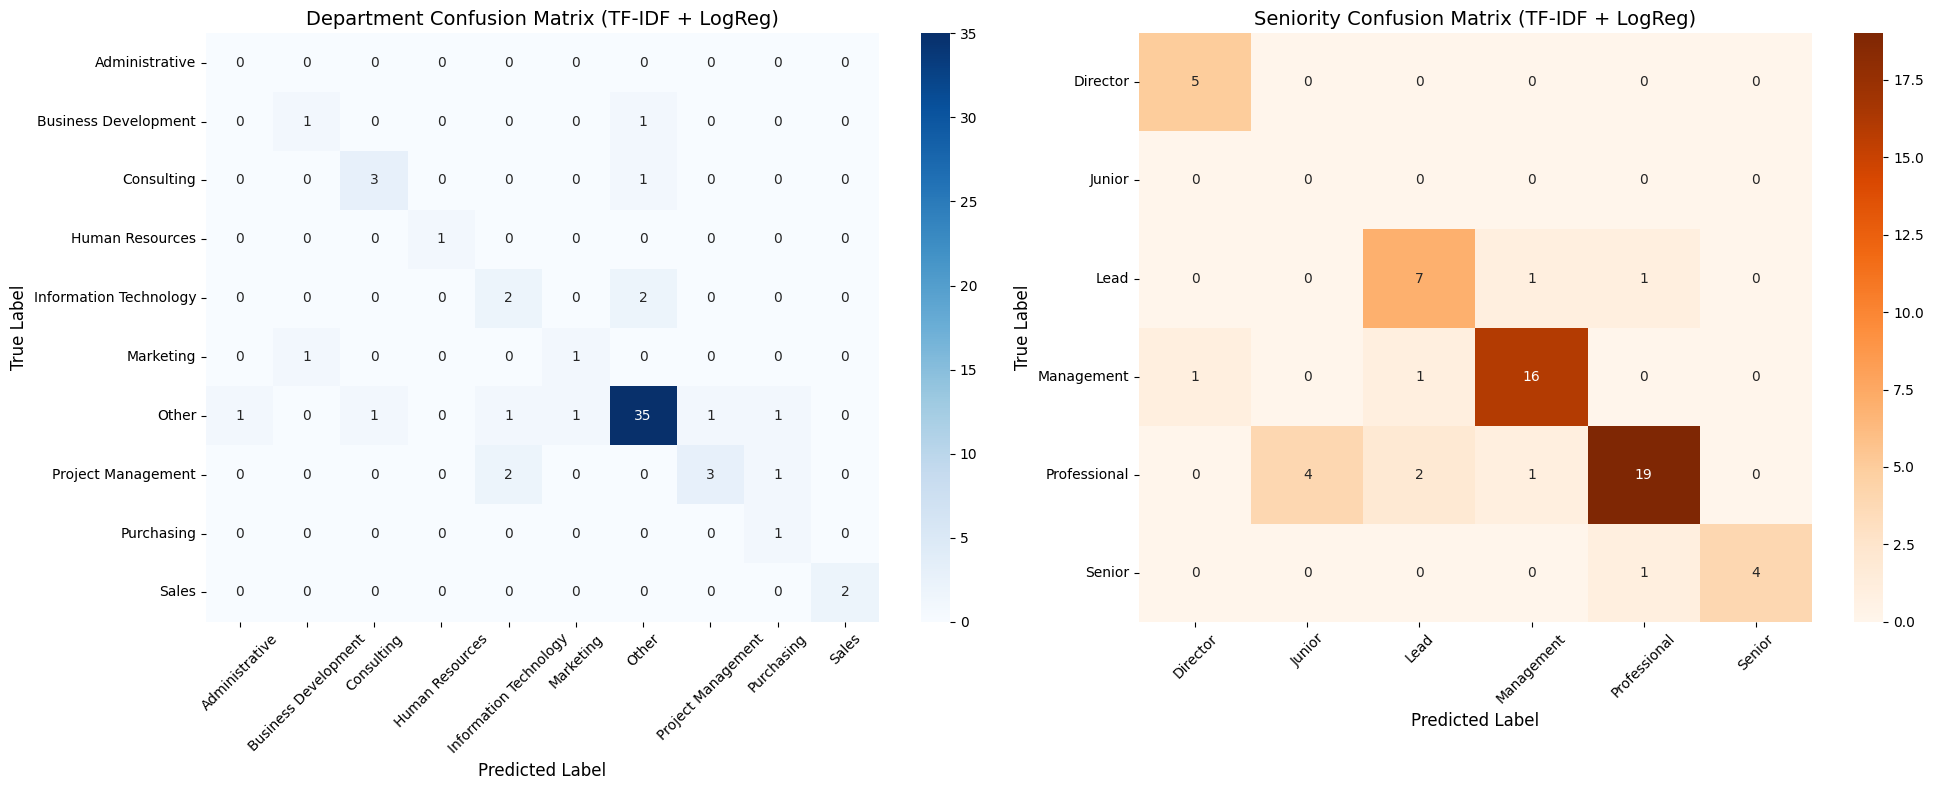

In [14]:
# Create confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Department confusion matrix (left)
dept_cm = confusion_matrix(dept_true, dept_predictions)
dept_labels = sorted(set(dept_true + list(dept_predictions)))

sns.heatmap(dept_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels, yticklabels=dept_labels, ax=axes[0])
axes[0].set_title('Department Confusion Matrix (TF-IDF + LogReg)', fontsize=14)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', rotation=0, labelsize=10)

# Seniority confusion matrix (right)
sen_cm = confusion_matrix(sen_true, sen_predictions)
sen_labels = sorted(set(sen_true + list(sen_predictions)))

sns.heatmap(sen_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels, ax=axes[1])
axes[1].set_title('Seniority Confusion Matrix (TF-IDF + LogReg)', fontsize=14)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', rotation=0, labelsize=10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tfidf_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Summary of Test Set Performance
print("\n" + "="*80)
print("FINAL PERFORMANCE SUMMARY - Test Set (Annotated LinkedIn CVs)")
print("="*80)
print(f"Department Accuracy:       {dept_metrics['accuracy']:.3f}")
print(f"Department F1 (macro):     {dept_metrics['f1_macro']:.3f}")
print(f"Department F1 (weighted):  {dept_metrics['f1_weighted']:.3f}")
print(f"\nSeniority Accuracy:        {sen_metrics['accuracy']:.3f}")
print(f"Seniority F1 (macro):      {sen_metrics['f1_macro']:.3f}")
print(f"Seniority F1 (weighted):   {sen_metrics['f1_weighted']:.3f}")
print("="*80)


FINAL PERFORMANCE SUMMARY - Test Set (Annotated LinkedIn CVs)
Department Accuracy:       0.778
Department F1 (macro):     0.617
Department F1 (weighted):  0.790

Seniority Accuracy:        0.810
Seniority F1 (macro):      0.705
Seniority F1 (weighted):   0.836


## 9. Inference on Unannotated Data

In [16]:
def predict_unannotated_cvs(cvs: List[Dict], dept_vectorizer, dept_classifier,
                           sen_vectorizer, sen_classifier) -> List[Dict]:
    """
    Add predictions to unannotated CVs.
    
    Args:
        cvs: List of unannotated CV dictionaries
        dept_vectorizer: Department TF-IDF vectorizer
        dept_classifier: Department classifier
        sen_vectorizer: Seniority TF-IDF vectorizer
        sen_classifier: Seniority classifier
        
    Returns:
        CVs with added predictions
    """
    predicted_cvs = []
    
    for cv in cvs:
        if isinstance(cv, list):
            entries = cv
        else:
            entries = cv.get('positions', [])
        
        predicted_entries = []
        for entry in entries:
            if not isinstance(entry, dict):
                predicted_entries.append(entry)
                continue
            
            # Create input text
            text = create_input_text(entry, include_org=True)
            
            # Predict department
            dept_X = dept_vectorizer.transform([text])
            dept_pred = dept_classifier.predict(dept_X)[0]
            dept_proba = dept_classifier.predict_proba(dept_X)[0].max()
            
            # Predict seniority
            sen_X = sen_vectorizer.transform([text])
            sen_pred = sen_classifier.predict(sen_X)[0]
            sen_proba = sen_classifier.predict_proba(sen_X)[0].max()
            
            # Add predictions to entry
            entry_with_pred = entry.copy()
            entry_with_pred['department_pred'] = dept_pred
            entry_with_pred['department_confidence'] = float(dept_proba)
            entry_with_pred['seniority_pred'] = sen_pred
            entry_with_pred['seniority_confidence'] = float(sen_proba)
            
            predicted_entries.append(entry_with_pred)
        
        if isinstance(cv, list):
            predicted_cvs.append(predicted_entries)
        else:
            cv_with_pred = cv.copy()
            cv_with_pred['positions'] = predicted_entries
            predicted_cvs.append(cv_with_pred)
    
    return predicted_cvs


# Load unannotated CVs
print("Loading unannotated CVs for inference...")
try:
    unannotated_cvs = load_linkedin_cvs(DATA_DIR / 'linkedin-cvs-not-annotated.json')
    print(f"Loaded {len(unannotated_cvs)} unannotated CVs")
    
    # Make predictions
    print("\nRunning inference on unannotated CVs...")
    predicted_cvs = predict_unannotated_cvs(
        unannotated_cvs, 
        dept_vectorizer, dept_classifier,
        sen_vectorizer, sen_classifier
    )
    
    # Save predictions
    output_path = DATA_DIR / 'processed' / 'linkedin-cvs-predictions.json'
    output_path.parent.mkdir(exist_ok=True)
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(predicted_cvs, f, indent=2, ensure_ascii=False)
    
    print(f"Predictions saved to: {output_path}")
    
    # Count ACTIVE predictions
    active_count = 0
    for cv in predicted_cvs:
        entries = cv if isinstance(cv, list) else cv.get('positions', [])
        active_count += sum(1 for e in entries if e.get('status', '').upper() == 'ACTIVE')
    
    print(f"   Predicted {active_count} ACTIVE entries")
    
except FileNotFoundError:
    print("Unannotated CV file not found, skipping inference")

Loading unannotated CVs for inference...
Loaded 390 unannotated CVs

Running inference on unannotated CVs...
Predictions saved to: ..\data\processed\linkedin-cvs-predictions.json
   Predicted 419 ACTIVE entries


## 10. Save Results and Models

In [17]:
# Prepare results dictionary
results = {
    "approach": "Hybrid: Rule-Based (exact matches) + TF-IDF LogReg (rest)",
    "timestamp": datetime.now().isoformat(),
    "data_split": {
        "cv_level_split": True,
        "train_cvs": len(train_cv_idx),
        "val_cvs": len(val_cv_idx),
        "test_cvs": len(test_cv_idx),
        "train_entries_total": len(train_df),
        "val_entries_active": len(val_active_df),
        "test_entries_active": len(test_active_df)
    },
    "features": {
        "word_ngrams": "(1, 2)",
        "char_ngrams": "(3, 5)",
        "dept_features": dept_X_train.shape[1],
        "sen_features": sen_X_train.shape[1]
    },
    "department": {
        "approach": "hybrid",
        "exact_matches": dept_metrics.get('exact_matches', 0),
        "tfidf_matches": dept_metrics.get('tfidf_matches', 0),
        "validation_accuracy": float(dept_val_acc),
        **dept_metrics
    },
    "seniority": {
        "approach": "tfidf_only",
        "validation_accuracy": float(sen_val_acc),
        **sen_metrics
    },
    "config": {
        "random_seed": RANDOM_SEED,
        "classifier": "LogisticRegression",
        "C": 1.0,
        "class_weight": "balanced",
        "hybrid_strategy": "rule_based_exact_then_tfidf"
    }
}

# Save results
results_path = RESULTS_DIR / 'hybrid_rulebased_tfidf_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to: {results_path}")

# Save models
import pickle

dept_hybrid_model = {
    'tfidf_vectorizer': dept_vectorizer,
    'tfidf_classifier': dept_classifier,
    'rule_classifier': dept_clf_rule,
    'classes': dept_classifier.classes_.tolist(),
    'approach': 'hybrid'
}

sen_model = {
    'vectorizer': sen_vectorizer,
    'classifier': sen_classifier,
    'classes': sen_classifier.classes_.tolist(),
    'approach': 'tfidf_only'
}

with open(MODELS_DIR / 'hybrid_department.pkl', 'wb') as f:
    pickle.dump(dept_hybrid_model, f)

with open(MODELS_DIR / 'tfidf_seniority.pkl', 'wb') as f:
    pickle.dump(sen_model, f)

print(f"Models saved to: {MODELS_DIR}")


Results saved to: results\hybrid_rulebased_tfidf_results.json
Models saved to: ..\models


## 11. Summary

**Key Implementation Details**:
- **Hybrid Department Classification**: Rule-based for exact matches (100% accuracy) + TF-IDF for rest
- **Pure TF-IDF Seniority Classification**
- CV-level splitting (no data leakage)
- Training on ALL entries (ACTIVE + INACTIVE)
- Evaluation on ACTIVE entries only
- TF-IDF with word (1-2) + character (3-5) n-grams
- Robust handling of missing fields
- Reproducible results (fixed random seed)
- Inference on unannotated data

**Hybrid Approach Benefits**:
- Leverages 100% accuracy of rule-based for exact matches
- Uses ML power for ambiguous cases
- Best of both worlds: precision + generalization

**Next Steps**:
- Fine-tune TF-IDF hyperparameters
- Experiment with different confidence thresholds
- Try hybrid approach for seniority as well